## This notebook is for the woodscape challenge 

In [1]:
import torch, torchvision
import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

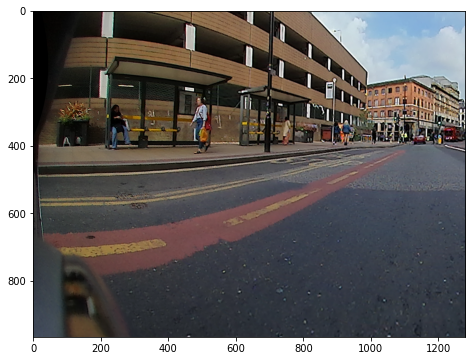

In [2]:
import mmcv
import matplotlib.pyplot as plt

data_dir = "/media/user/Seagate Expansion Drive/rectified_images/dataset_rectified"
img_dir = 'images'
ann_dir = 'labels'
img = mmcv.imread(data_dir+'/images/00004_FVL.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

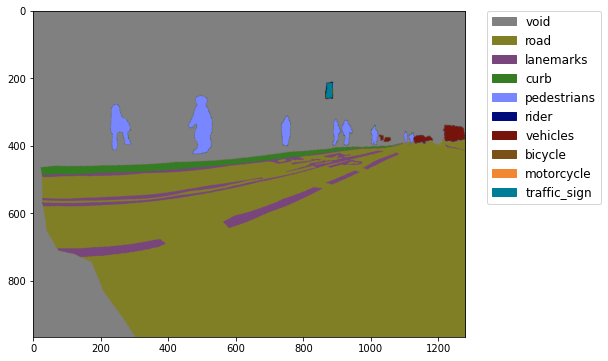

In [3]:
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np

classes = ('void','road', 'lanemarks', 'curb', 'pedestrians', 'rider', 'vehicles', 'bicycle', 'motorcycle', 'traffic_sign')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], [120, 134, 255],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51], [0, 125, 151]]

img = np.array(Image.open(data_dir+'/labels/00004_FVL.png'))
seg_img = Image.fromarray(img[:,:,1]).convert('P')                 
seg_img.putpalette(np.array(palette, dtype=np.uint8))

plt.figure(figsize=(8, 6))
plt.imshow(seg_img)

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(10)]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [4]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class Woodscape(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='_.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [5]:
from mmcv import Config
cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [6]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 11
cfg.model.auxiliary_head.num_classes = 11

# Modify dataset type and path
cfg.dataset_type = 'Woodscape'
cfg.data_root = data_dir

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')



Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=11,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=

In [7]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp
from ipywidgets import IntProgress

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


print(model)

/home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-06-11 15:07:08,111 - mmseg - INFO - Loaded 13174 images
2021-06-11 15:07:08,615 - mmseg - INFO - Use load_from_openmmlab loader
2021-06-11 15:07:08,700 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



EncoderDecoder(
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [8]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=False, 
                meta=dict())

2021-06-11 15:07:10,841 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-06-11 15:07:10,842 - mmseg - INFO - Use load_from_local loader
2021-06-11 15:07:11,266 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([11, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([11]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([11, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([11]).
2021-06-11 15:07:11,273

RuntimeError: CUDA error: an illegal memory access was encountered (process_events at /pytorch/c10/cuda/CUDACachingAllocator.cpp:799)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x46 (0x7f79ed556536 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1d4bd (0x7f79ed7a04bd in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1df9e (0x7f79ed7a0f9e in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x135 (0x7f79f034cfd5 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xf9310b (0x7f79ee94510b in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xfdc9f7 (0x7f79ee98e9f7 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0x1075389 (0x7f7a262d9389 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0x10756c7 (0x7f7a262d96c7 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xe2165e (0x7f7a2608565e in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::native::empty_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x9e0 (0x7f7a2608bf50 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: <unknown function> + 0x1134321 (0x7f7a26398321 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x1187623 (0x7f7a263eb623 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0xe1fb8a (0x7f7a26083b8a in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::native::zeros_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x4c (0x7f7a2608a17c in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x1140974 (0x7f7a263a4974 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x1187623 (0x7f7a263eb623 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: at::native::adaptive_avg_pool2d_backward_cuda(at::Tensor const&, at::Tensor const&) + 0x167 (0x7f79ef4b6477 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0xfc2f5e (0x7f79ee974f5e in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #18: <unknown function> + 0x10c3ec0 (0x7f7a26327ec0 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2bd7a38 (0x7f7a27e3ba38 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0x10c3ec0 (0x7f7a26327ec0 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: at::Tensor c10::Dispatcher::callUnboxed<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::OperatorHandle const&, at::Tensor const&, at::Tensor const&) const + 0xb3 (0x7f7a40685be3 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #22: torch::autograd::generated::AdaptiveAvgPool2DBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0xf7 (0x7f7a27b03767 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x2d89c05 (0x7f7a27fedc05 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f7a27feaf03 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f7a27febce2 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f7a27fe4359 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f7a40949828 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #28: <unknown function> + 0xc9039 (0x7f7a52603039 in /home/user/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #29: <unknown function> + 0x76db (0x7f7a54cb66db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #30: clone + 0x3f (0x7f7a549df71f in /lib/x86_64-linux-gnu/libc.so.6)


In [ ]:
img = mmcv.imread(data_dir+'/images/00004_FVL.png')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)
